In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from scipy import stats
import statsmodels.api as sm
import math
import re
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import sys
import pandas.core.algorithms as algos
pd.pandas.set_option('display.max_columns',None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train = pd.read_csv("./drive/MyDrive/train.csv")

In [5]:
train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [6]:
train.shape

(20800, 5)

In [7]:
features=[i for i  in train.columns if i not in ['label']]

In [8]:
features

['id', 'title', 'author', 'text']

In [9]:
train.shape

(20800, 5)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [11]:
train.fillna('unavailable',inplace=True)

In [12]:
test=pd.read_csv('./drive/MyDrive/test.csv')

In [13]:
test.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
dtypes: int64(1), object(3)
memory usage: 162.6+ KB


In [15]:
test.fillna('unavailable',inplace=True)

In [16]:
df=pd.concat([train,test],axis='rows')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26000 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      26000 non-null  int64  
 1   title   26000 non-null  object 
 2   author  26000 non-null  object 
 3   text    26000 non-null  object 
 4   label   20800 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.2+ MB


In [18]:
df['comb']=df['author']+"_"+df['title']+" "+df['text']

In [19]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [20]:
import string
import re
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [21]:
wordnet=WordNetLemmatizer()
stemmer=PorterStemmer()
def clean(text):
  # text="".join([char for char in text if char not in string.punctuation])
  text="".join([re.sub('[^a-zA-Z]',' ',char) for char in text ])
  text=text.lower()
  text=text.split()
  text=[stemmer.stem(word) for word in text if word not in set(stopwords.words("english"))]
  text=" ".join(text)
  return text

In [22]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed May 25 18:10:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
df['comb']=df['comb'].apply(clean)

In [24]:
df.head()

,id,title,author,text,label,comb
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1.0,darrel lucu hous dem aid even see comey letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0.0,daniel j flynn flynn hillari clinton big woman...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1.0,consortiumnew com truth might get fire truth m...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1.0,jessica purkiss civilian kill singl us airstri...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1.0,howard portnoy iranian woman jail fiction unpu...


In [25]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 462 kB 4.3 MB/s 


In [26]:
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from sklearn import metrics
import numpy as np
import itertools
import sklearn

In [27]:
voc_size=10000 

In [29]:
title=df['comb']
title[0]

0    darrel lucu hous dem aid even see comey letter...
0    david streitfeld specter trump loosen tongu pu...
Name: comb, dtype: object

In [30]:
one_hot_r=[one_hot(words, voc_size) for words in title]

In [31]:
one_hot_r[0:2]

[[6742,
  7887,
  4113,
  2426,
  4204,
  6032,
  9907,
  5568,
  5855,
  1108,
  359,
  6806,
  4113,
  2426,
  4204,
  6032,
  9907,
  5568,
  5855,
  1108,
  359,
  6806,
  6742,
  7887,
  3116,
  4080,
  1108,
  359,
  2963,
  9435,
  1844,
  6572,
  9504,
  1299,
  5801,
  515,
  8165,
  4432,
  6813,
  1526,
  3174,
  3032,
  4128,
  2010,
  4069,
  5248,
  6406,
  2975,
  8810,
  5064,
  5807,
  5568,
  7951,
  4113,
  2737,
  4204,
  5373,
  1286,
  6152,
  7965,
  3759,
  4069,
  5248,
  377,
  789,
  5568,
  9420,
  7219,
  5855,
  3760,
  8810,
  5373,
  7433,
  8322,
  8191,
  6392,
  6065,
  7433,
  44,
  1078,
  2737,
  3732,
  818,
  1234,
  5568,
  3135,
  6932,
  6806,
  4003,
  6692,
  818,
  7509,
  7965,
  5568,
  8699,
  6692,
  7509,
  2737,
  1078,
  7424,
  4113,
  8615,
  3068,
  9640,
  818,
  5259,
  2135,
  7433,
  5535,
  7345,
  3666,
  9907,
  2703,
  7577,
  7509,
  448,
  5855,
  8854,
  9640,
  818,
  1472,
  1108,
  359,
  8553,
  7291,
  6406,
  4818

In [32]:
sent_len=30
embedded_docs=pad_sequences(one_hot_r,padding='post',maxlen=sent_len)

In [33]:
embedded_docs[:10]

array([[6147, 5781, 3292, 6019, 3693, 3715, 9666, 1839, 1744, 3688, 7247,
        7131, 8322, 7965,  876,  275, 7053, 2426, 2090, 7751, 9450, 6496,
          50,  603, 2587, 2470, 6742, 5489, 6681,   50],
       [9031, 7425, 6847, 2653, 8322, 6847, 8828,  387, 7547, 4703, 5002,
        1669, 4421, 5513, 9656, 8513, 1480, 8008, 4227, 4303, 7877, 1286,
        3177, 6232, 7207, 4913, 7877, 2769, 7761, 4730],
       [9569, 2504,  571, 4035,  562, 5475, 2014, 9703, 7833, 6817, 1675,
        4874, 3190, 8615,  958, 9907, 9817, 3093, 1244, 5192, 3484, 4021,
        2429,  868, 5441, 1235, 5504, 4068, 2220, 3738],
       [2680, 7877, 4003, 7062, 4726, 5273, 5749, 6253, 7222, 7409, 2497,
        7720, 6955, 2779,  415, 7062, 6405, 8447, 7278, 6955, 9435, 3757,
        8001, 2681, 6253, 9497, 7747, 7720, 5362, 3517],
       [8001, 1676, 2169, 8904, 4003, 2297, 2764, 6525, 5576,  179, 9957,
        2279, 2771, 2804, 2771, 2986, 6815, 2169, 8904, 1443, 7751, 6525,
        5645, 1125, 3183, 5576, 

In [34]:
sgd=tensorflow.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6,momentum=0.9, nesterov=True)
rms = tensorflow.keras.optimizers.RMSprop()
nadam=tensorflow.keras.optimizers.Nadam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name="Nadam"
)

In [35]:
embedding_vector_features= 50 #'"Incorporando recursos do vetor'
model=Sequential() #Inicializar o modelo sequencial
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_len))
model.add(Dropout(0.1)) # '"funciona zerando aleatoriamente uma percentagens de neurônios nas camadas"
model.add(Bidirectional(LSTM(100)))  # used Bidirectional LSTM
model.add(Dropout(0.1)) #Camadas adicionadas 
model.add(Dense(1,activation='sigmoid')) #Tipo de camada do Keras, junto a função Sigmoid
model.compile(loss='binary_crossentropy',optimizer=nadam,metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 50)            500000    
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              120800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 621,001
Trainable params: 621,001
Non-trainable params: 0
__________________________________________________

In [36]:
len(embedded_docs)

26000

In [37]:
X=embedded_docs[:train.shape[0]]
y=df['label'][:train.shape[0]]
x_test=embedded_docs[train.shape[0]:]

In [38]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
model.fit(X_train,y_train,validation_data=(x_valid,y_valid),epochs=25,batch_size=124)

Epoch 1/25
135/135 [==============================] - 10s 15ms/step - loss: 0.3686 - accuracy: 0.8238 - val_loss: 0.2975 - val_accuracy: 0.8656
Epoch 2/25
135/135 [==============================] - 1s 9ms/step - loss: 0.2056 - accuracy: 0.9171 - val_loss: 0.2925 - val_accuracy: 0.8767
Epoch 3/25
135/135 [==============================] - 1s 9ms/step - loss: 0.1435 - accuracy: 0.9438 - val_loss: 0.3741 - val_accuracy: 0.8649
Epoch 4/25
135/135 [==============================] - 1s 9ms/step - loss: 0.0986 - accuracy: 0.9623 - val_loss: 0.4177 - val_accuracy: 0.8750
Epoch 5/25
135/135 [==============================] - 1s 9ms/step - loss: 0.0649 - accuracy: 0.9775 - val_loss: 0.5002 - val_accuracy: 0.8639
Epoch 6/25
135/135 [==============================] - 1s 9ms/step - loss: 0.0508 - accuracy: 0.9816 - val_loss: 0.5252 - val_accuracy: 0.8704
Epoch 7/25
135/135 [==============================] - 1s 9ms/step - loss: 0.0334 - accuracy: 0.9881 - val_loss: 0.6082 - val_accuracy: 0.8627
Epoc

In [40]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

In [41]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_valid, y_pred_valid)

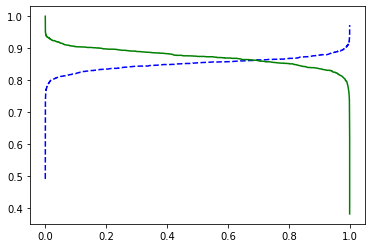

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
[...]
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [43]:
def cutoff_youdens_j(fpr,tpr,thresholds):
  a = tpr-fpr
  b = sorted(zip(a,thresholds))
  return b[-1][1] 

In [44]:
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_valid)

In [45]:
cutoff = cutoff_youdens_j(fpr, tpr, threshold)

In [46]:
A=[]
B=[]
C=[]
for i in range(len(threshold)):
  predicted = pd.DataFrame()
  predicted["label"] = y_pred_prob
  predicted["label"] = np.where(predicted["label"] > float(threshold[i]), 1, 0)
  pred_valid = pd.DataFrame()
  pred_valid["label"] = y_pred_valid
  pred_valid["label"] = np.where(pred_valid["label"] > float(threshold[i]), 1, 0)
  A.append(metrics.accuracy_score(y_train, predicted))
  B.append(metrics.accuracy_score(y_valid, pred_valid))
  C.append(threshold[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [47]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,1
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,1


In [48]:
#MATRIZ
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Purples):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [49]:
from sklearn.metrics import roc_auc_score

In [50]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
score = metrics.accuracy_score(y_train, predicted)
print(conf_matrix)
print(score)

[[8252    3]
 [   1 8384]]
0.9997596153846153


accuracy:   1.000
Confusion matrix, without normalization


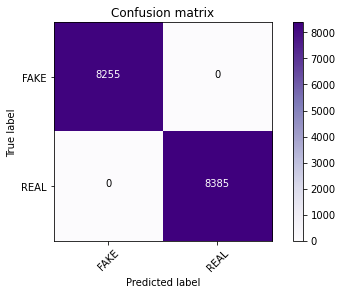

In [51]:
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y_train, y_train)
plot_confusion_matrix(cm1, normalize=False, classes=['FAKE', 'REAL'])

In [52]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
score = metrics.accuracy_score(y_valid, pred_valid)
print(conf_matrix)
print(score)

[[1837  295]
 [ 258 1770]]
0.8670673076923077


accuracy:   0.867
Confusion matrix, without normalization


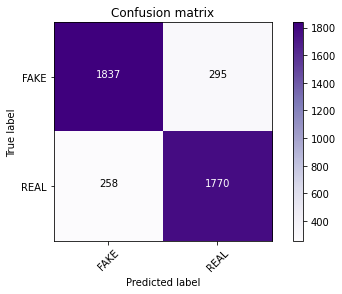

In [53]:
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y_valid, pred_valid)
plot_confusion_matrix(cm1, normalize=False, classes=['FAKE', 'REAL'])

In [54]:
X_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
model.fit(X_train,y_train,validation_data=(x_valid,y_valid),epochs=25,batch_size=124)

Epoch 1/25
118/118 [==============================] - 1s 10ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.7016 - val_accuracy: 0.9071
Epoch 2/25
118/118 [==============================] - 1s 9ms/step - loss: 0.0048 - accuracy: 0.9984 - val_loss: 0.7482 - val_accuracy: 0.9038
Epoch 3/25
118/118 [==============================] - 1s 10ms/step - loss: 0.0031 - accuracy: 0.9990 - val_loss: 0.7400 - val_accuracy: 0.9082
Epoch 4/25
118/118 [==============================] - 1s 9ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.7266 - val_accuracy: 0.9083
Epoch 5/25
118/118 [==============================] - 1s 10ms/step - loss: 9.6202e-04 - accuracy: 0.9999 - val_loss: 0.8113 - val_accuracy: 0.9079
Epoch 6/25
118/118 [==============================] - 1s 10ms/step - loss: 5.1729e-04 - accuracy: 0.9999 - val_loss: 0.8435 - val_accuracy: 0.9058
Epoch 7/25
118/118 [==============================] - 1s 10ms/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.7115 - val_accuracy: 

In [56]:
y_pred_prob=np.array(model.predict(X_train))[:,0]
y_pred_valid=np.array(model.predict(x_valid))[:,0]
y_pred=np.array(model.predict(x_test))[:,0]

In [57]:
fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred_valid)

In [58]:
cutoff = cutoff_youdens_j(fpr, tpr, threshold)

In [59]:
A=[]
B=[]
C=[]
for i in range(len(threshold)):
  predicted = pd.DataFrame()
  predicted["label"] = y_pred_prob
  predicted["label"] = np.where(predicted["label"] > float(threshold[i]), 1, 0)
  pred_valid = pd.DataFrame()
  pred_valid["label"] = y_pred_valid
  pred_valid["label"] = np.where(pred_valid["label"] > float(threshold[i]), 1, 0)
  A.append(metrics.accuracy_score(y_train, predicted))
  B.append(metrics.accuracy_score(y_valid, pred_valid))
  C.append(threshold[i])
acc=pd.DataFrame(C,columns=['threshold'])
acc['train_acc']=A
acc['test_acc']=B
acc.sort_values(by='test_acc',ascending=False,inplace=True)

In [60]:
predicted = pd.DataFrame()
predicted["label"] = y_pred_prob
predicted["label"] = np.where(predicted["label"] > float(cutoff), 1, 0)
predicted

pred_valid = pd.DataFrame()
pred_valid["label"] = y_pred_valid
pred_valid["label"] = np.where(pred_valid["label"] > float(cutoff), 1, 0)
pred_valid

predictions = pd.DataFrame()
predictions['label'] = y_pred
predictions['label'] = np.where(predictions['label'] > float(cutoff), 1, 0)
predictions

,label
0,1
1,1
2,1
3,0
4,1
...,...
5195,0
5196,0
5197,0
5198,1


In [61]:
conf_matrix = metrics.confusion_matrix(y_train, predicted)
score = metrics.accuracy_score(y_train, predicted)
print(conf_matrix)
print(score)

[[7238    1]
 [   1 7320]]
0.9998626373626374


accuracy:   1.000
Confusion matrix, without normalization


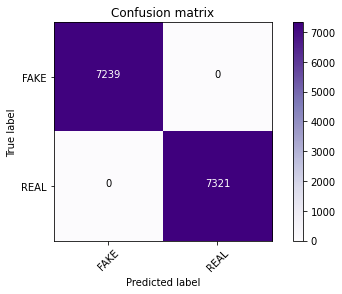

In [62]:
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y_train, y_train)
plot_confusion_matrix(cm1, normalize=False, classes=['FAKE', 'REAL'])

In [63]:
conf_matrix = metrics.confusion_matrix(y_valid, pred_valid)
score = metrics.accuracy_score(y_valid, pred_valid)
print(conf_matrix)
print(score)

[[2858  290]
 [ 325 2767]]
0.9014423076923077


accuracy:   0.901
Confusion matrix, without normalization


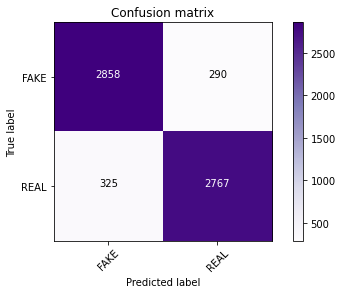

In [64]:
print("accuracy:   %0.3f" % score)
cm1 = metrics.confusion_matrix(y_valid, pred_valid)
plot_confusion_matrix(cm1, normalize=False, classes=['FAKE', 'REAL'])